In [33]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, SlopeOne, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote_auto.csv')
print("df_under is the oversample data frame\n", data.rate.value_counts().sort_index())

df_under is the oversample data frame
 1    261
2    261
3    261
4    261
5    261
Name: rate, dtype: int64


In [34]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


## Non-Negative Matrix Factorization

In [35]:
class Slopeone (SlopeOne):
    def __init__(self):
       SlopeOne.__init__(self)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            SlopeOne.fit(self, trainset_fold)
            train_prediction = SlopeOne.test(self, trainset_fold.build_testset())
            prediction = SlopeOne.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = SlopeOne.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## SVD and SGD

The minimization is performed by a very straightforward stochastic gradient descent:
* note You can choose to use an unbiased version of this algorithm
* verbose – If True, prints the current epoch. Default is False.

In [36]:
slope_one = Slopeone()

slope_one.create_reader(data)
predictions = slope_one.fit()
#acc
metrics = slope_one.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'Slope One'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.1041
RMSE: 0.6526
RMSE: 0.0667
RMSE: 0.7231
RMSE: 0.0969
RMSE: 0.8187
RMSE: 0.0731
RMSE: 0.8520
RMSE: 0.0957
RMSE: 0.8683
###############################################
The Results are: 

Average RMSE on Training Set: 0.08726779095885986
Average RMSE on Test Set: 0.7829448438537058
RMSE: 0.8083
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8082934183152808
RMSE: 0.8083
MAE:  0.4292
MSE: 0.6533
Precision: 0.20
Recall: 0.15
the acc is 68.58


/tmp/ipykernel_6582/1036612676.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [37]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,RMSE,MAE,MSE,Precision,Recall,Accuracy
0,1,Slope One,0.808293,0.429156,0.653338,0.196667,0.148342,68.582375


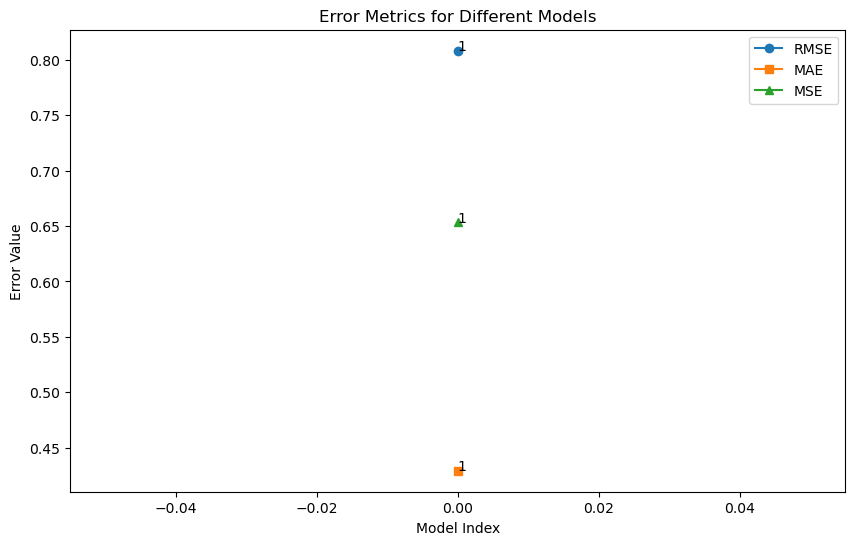

In [38]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

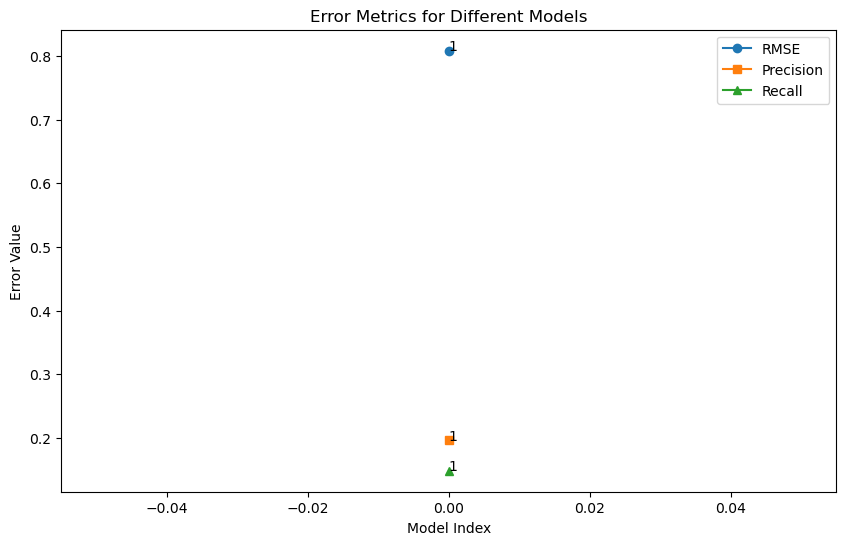

In [39]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

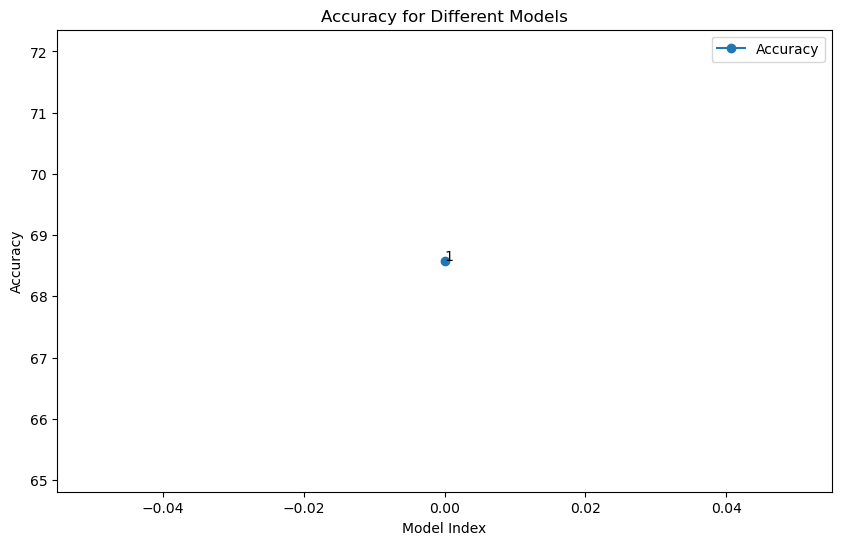

In [40]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [41]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = slope_one.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Anjou Blanc
2. Item ID: Rheinhessen Kabinett Riesling
3. Item ID: Pinot blanc
4. Item ID: Théophile Brut Champagne
5. Item ID: Cirus Madiran
6. Item ID: Beyerskloof Western Cape
7. Item ID: Cirus Madiran
8. Item ID: Beyerskloof Western Cape
9. Item ID: Cirus Madiran
10. Item ID: Cirus Madiran


In [42]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = slope_one.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: d48fd3bd-06e9-4368-97b9-aae545388325
2. User ID: 918cd9b7-8057-4106-8f7f-9e9e3a423fb1


In [43]:
#get the KnnWithMeans for a user from the model
slope_one.get_neighbors_uid(user_id=5)

['5ccd8030-047b-432c-a630-d784ab415756',
 '99654a70-c3bb-46f4-8697-b9345482e48d',
 'ecc462e1-5041-43ca-94c3-c2bfc9b3215e',
 'defee34b-7775-4889-b703-92b730d85e70',
 '91cf68cc-9436-43e1-871d-33beef4d2337',
 '25a04c51-5638-42f0-b2e7-ce49b1c280fc',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 '014e4ed1-6f8b-4b25-917d-c167a2acca17',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 '00324bc3-0b35-4051-bc6d-9c258a4252c2']

In [44]:
#get the KnnWithMeans for an item from the model
slope_one.get_neighbors_iid(item_id=20)

['Collio bianco riserva',
 'Franciacorta',
 'Bread & Butter Pinor Noir 2020',
 'Il Mattaglio Blanc de Blancs',
 'Ronco del Balbo Merlot',
 'Amarone',
 "The Society's Exhibition Shiraz",
 'Cabernet Sauvignon',
 'Fumin la griffe',
 'Zamò Bianco']

In [45]:
slope_one.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(slope_one.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 12 with sim 0.000000000000000
And the baseline estimate is: 2.693219432713392

#####

Note: If the baseline is 2.986842105263158 then the value is a default value, Otherwise not


In [46]:
df_pred = slope_one.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.000000,{'was_impossible': False},47,48,0.000000
1,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Rheinhessen Kabinett Riesling,1.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",49,0,1.986842
2,5ccd8030-047b-432c-a630-d784ab415756,Blanc de Noir,3.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",70,0,0.013158
3,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,5.000000,{'was_impossible': False},36,15,0.000000
4,5ccd8030-047b-432c-a630-d784ab415756,Soave classico,3.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",70,0,0.013158
5,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.000000,{'was_impossible': False},124,115,0.000000
6,00324bc3-0b35-4051-bc6d-9c258a4252c2,Cavalcaonte Barbera Forlí,5.0,5.000000,{'was_impossible': False},20,20,0.000000
7,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.000000,{'was_impossible': False},124,115,0.000000
8,5ccd8030-047b-432c-a630-d784ab415756,Côtes du Rhône Cuvée Pierre Perrin,3.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",70,0,0.013158
9,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Traminer Komjanc,3.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",124,0,0.013158


* best predictions

In [47]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
0,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.0,{'was_impossible': False},47,48,0.0
148,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Cirus Madiran,2.0,2.0,{'was_impossible': False},49,22,0.0
149,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,{'was_impossible': False},124,115,0.0
153,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,{'was_impossible': False},124,115,0.0
155,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,5.0,{'was_impossible': False},36,15,0.0
157,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,5.0,{'was_impossible': False},36,15,0.0
158,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,{'was_impossible': False},124,115,0.0
159,5ccd8030-047b-432c-a630-d784ab415756,Acinaia,2.0,2.0,{'was_impossible': False},70,20,0.0
147,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,5.0,{'was_impossible': False},36,15,0.0
160,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Chardonnay Cardellino,5.0,5.0,{'was_impossible': False},57,10,0.0


* worst predictions

In [48]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
200,bc79b0e3-064d-4240-86de-e86499f577e8,Roero Arneis,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",36,0,2.013158
60,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Ormeasco di Pornassio,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",3,0,2.013158
34,2f3064a7-12af-43d8-90fd-6c4555830fcc,Cabernet Sauvignon,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",0,6,2.013158
182,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Chateauneuf du pape,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",36,0,2.013158
38,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Vieilles Vignes Rouge,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",57,0,2.013158
164,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 10,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",36,0,2.013158
234,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 5,5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",36,0,2.013158
83,22c5c1cb-88fd-4870-a911-846516978ed4,Malbec (High Mountain Vines),5.0,2.986842,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.013158
115,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Cabernet Franc,4.0,1.322581,{'was_impossible': False},124,3,2.677419
176,4ed273f7-1816-4f36-88c7-789125f011c7,Moscato d'Asti,1.0,5.000000,{'was_impossible': False},14,1,4.000000
